In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
from itertools import product
from functions import (load_parameters, load_generation_data, load_price_data, generate_randomized_generation,
generate_rt_scenarios, plot_generation_data, plot_randomized_generation, plot_scenarios_for_generator, plot_rt_scenarios)

generation_data, I, T = load_generation_data(date_filter="2022-07-18")
S, R, P_RT, K, K0, M1, M2 = load_parameters(I, T, generation_data)
P_DA, P_PN = load_price_data()

✅ 총 5개 파일을 불러왔습니다: 1201.csv, 137.csv, 401.csv, 524.csv, 89.csv
📊 데이터 Shape: I=5, T=24, S=10
✅ 시뮬레이션 초기화 완료: S=10, Randomness='high', M1=758.40, M2=1855.82


/Users/jangseohyun/Documents/workspace/symply/DER/functions.py:95: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  nyc_rt["Hour"] = nyc_rt["Time Stamp"].dt.floor("H")


In [ ]:
set= gp.Model("set")
set.setParam("MIPGap", 1e-7)

a = set.addVars(T, vtype=GRB.CONTINUOUS, name="alpha")
bp = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_plus")
bm = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="beta_minus")
g = set.addVars(T+1, S, vtype=GRB.CONTINUOUS, name="gamma")
gc = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_charge")
gd = set.addVars(T, S, vtype=GRB.CONTINUOUS, name="gamma_discharge")
eta = set.addVars(T, S, vtype=GRB.BINARY, name="eta")
lam = set.addVars(T, S, vtype=GRB.BINARY, name="lambda")
mu = set.addVars(T, S, vtype=GRB.BINARY, name="mu")

x = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="x")
yp = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_plus")
ym = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="y_minus")
z = set.addVars(I, T+1, S, vtype=GRB.CONTINUOUS, name="z")
zc = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_charge")
zd = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="z_discharge")
zeta = set.addVars(I, T, S, vtype=GRB.BINARY, name="zeta")
delta = set.addVars(I, T, S, vtype=GRB.BINARY, name="delta")
rho = set.addVars(I, T, S, vtype=GRB.BINARY, name="rho")

d = set.addVars(T, S, vtype=GRB.CONTINUOUS, lb=0, name="d")
dyy = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="dyy")
dyz = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="dyz")
dzy = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="dzy")
dzz = set.addVars(I, I, T, S, vtype=GRB.CONTINUOUS, lb=0, name="dzz")

e = set.addVars(I, T+1, S, vtype=GRB.CONTINUOUS, name="e")
ep = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_plus")
em = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_minus")
ec = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_charge")
ed = set.addVars(I, T, S, vtype=GRB.CONTINUOUS, name="e_discharge")

obj = gp.quicksum(P_DA[t] * a[t] for t in range(T)) + \
      gp.quicksum((1 / S) * (P_RT[t, s] * bp[t, s] - P_PN[t] * bm[t, s]) 
                for t in range(T) for s in range(S))
      
set.setObjective(obj, GRB.MAXIMIZE)                                                                                                                                                                                                                      

for t, s in product(range(T), range(S)):
    set.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) - a[t] == bp[t, s] - bm[t, s] + gc[t, s] - gd[t, s])
    set.addConstr(gp.quicksum(R[i, t, s] for i in range(I)) + g[t, s] >= bp[t, s])
    set.addConstr(g[t + 1, s] == g[t, s] + gc[t, s] - gd[t, s])
    set.addConstr(gd[t, s] <= g[t, s])
    set.addConstr(gc[t, s] <= sum(K) - g[t, s])
    set.addConstr(bp[t, s] <= M2 * mu[t, s])
    set.addConstr(bm[t, s] <= M2 * (1 - mu[t, s]))
    set.addConstr(bm[t, s] <= M2 * eta[t, s])
    set.addConstr(gc[t, s] <= M2 * (1 - eta[t, s]))
    set.addConstr(gc[t, s] <= M2 * lam[t, s])
    set.addConstr(gd[t, s] <= M2 * (1 - lam[t, s]))
for s in range(S):
    set.addConstr(g[0, s] == sum(K0))

for t, s in product(range(T), range(S)):
    set.addConstr(a[t] == gp.quicksum(x[i, t, s] for i in range(I)))
    set.addConstr(bp[t, s] == gp.quicksum(ep[i, t, s] for i in range(I)))
    set.addConstr(bm[t, s] == gp.quicksum(em[i, t, s] for i in range(I)))
    set.addConstr(g[t, s] == gp.quicksum(e[i, t, s] for i in range(I)))
    set.addConstr(gc[t, s] == gp.quicksum(ec[i, t, s] for i in range(I)))
    set.addConstr(gd[t, s] == gp.quicksum(ed[i, t, s] for i in range(I)))

for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(R[i, t, s] - x[i, t, s] == yp[i, t, s] - ym[i, t, s] + zc[i, t, s] - zd[i, t, s])
    set.addConstr(R[i, t, s] +  z[i, t, s] >= yp[i, t, s])
    set.addConstr(z[i, t + 1, s] == z[i, t, s] + zc[i, t, s] - zd[i, t, s])
    set.addConstr(zd[i, t, s] <= z[i, t, s])
    set.addConstr(zc[i, t, s] <= K[i] - z[i, t, s])
    set.addConstr(yp[i, t, s] <= M1 * rho[i, t, s])
    set.addConstr(ym[i, t, s] <= M1 * (1 - rho[i, t, s]))
    set.addConstr(ym[i, t, s] <= M1 * delta[i, t, s])
    set.addConstr(zc[i, t, s] <= M1 * (1 - delta[i, t, s]))
    set.addConstr(zc[i, t, s] <= M1 * zeta[i, t, s])
    set.addConstr(zd[i, t, s] <= M1 * (1 - zeta[i, t, s]))
for i, s in product(range(I), range(S)):
    set.addConstr(z[i, 0, s] == K0[i])

for t, s in product(range(T), range(S)):
    set.addConstr(d[t, s] == (gp.quicksum(yp[i, t, s] for i in range(I)) + gp.quicksum(ym[i, t, s] for i in range(I)) + gp.quicksum(zc[i, t, s] for i in range(I)) + gp.quicksum(zd[i, t, s] for i in range(I)) + gp.quicksum(z[i, t, s] for i in range(I))) 
                  - (bp[t, s] + bm[t, s] + gc[t, s] + gd[t, s] + g[t, s]))
    set.addConstr(d[t, s] == gp.quicksum(dyy[i, j, t, s] + dyz[i, j, t, s] + dzy[i, j, t, s] + dzz[i, j, t, s] for i in range(I) for j in range(I) if j != i))
    # set.addConstr(gp.quicksum(dyy[i, j, t, s] for i in range(I) for j in range(I) if j != i) ==
    #               gp.quicksum(dyy[j, i, t, s] for j in range(I) for i in range(I) if j != i))
    # set.addConstr(gp.quicksum(dyz[i, j, t, s] for i in range(I) for j in range(I) if j != i) ==
    #               gp.quicksum(dyz[j, i, t, s] for j in range(I) for i in range(I) if j != i))
    # set.addConstr(gp.quicksum(dzy[i, j, t, s] for i in range(I) for j in range(I) if j != i) ==
    #               gp.quicksum(dzy[j, i, t, s] for j in range(I) for i in range(I) if j != i))
    # set.addConstr(gp.quicksum(dzz[i, j, t, s] for i in range(I) for j in range(I) if j != i) ==
    #               gp.quicksum(dzz[j, i, t, s] for j in range(I) for i in range(I) if j != i))
for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(gp.quicksum(dyy[i, j, t, s] + dyz[i, j, t, s] + dzy[i, j, t, s] + dzz[i, j, t, s] for j in range(I) if j != i) <= yp[i, t, s] + zc[i, t, s] + z[i, t, s] - zd[i, t, s])
    set.addConstr(gp.quicksum(dyy[j, i, t, s] + dyz[j, i, t, s] + dzy[j, i, t, s] + dzz[j, i, t, s] for j in range(I) if j != i) <= ym[i, t, s] + zc[i, t, s] + zd[i, t, s])
    
    # set.addConstr(dyy[i, i, t, s] == 0)
    # set.addConstr(dyz[i, i, t, s] == 0)
    # set.addConstr(dzy[i, i, t, s] == 0)
    # set.addConstr(dzz[i, i, t, s] == 0)
    
for i, t, s in product(range(I), range(T), range(S)):
    set.addConstr(ep[i, t, s] == yp[i, t, s] - gp.quicksum(dyy[i, j, t, s] for j in range(I) if j != i) - gp.quicksum(dyz[i, j, t, s] for j in range(I) if j != i))
    set.addConstr(em[i, t, s] == ym[i, t, s] - gp.quicksum(dyy[j, i, t, s] for j in range(I) if j != i) - gp.quicksum(dyz[j, i, t, s] for j in range(I) if j != i))
    set.addConstr(ec[i, t, s] == zc[i, t, s] - gp.quicksum(dzz[i, j, t, s] for j in range(I) if j != i) - gp.quicksum(dzy[j, i, t, s] for j in range(I) if j != i))
    set.addConstr(ed[i, t, s] == zd[i, t, s] - gp.quicksum(dzz[j, i, t, s] for j in range(I) if j != i) - gp.quicksum(dzy[j, i, t, s] for j in range(I) if j != i))
    set.addConstr(e[i, t, s] == z[i, t, s] + ec[i, t, s] - ed[i, t, s])
    # set.addConstr(z[i, t + 1, s] == z[i, t, s] + ec[i, t, s] - ed[i, t, s])
    
set.optimize()

if set.status == GRB.OPTIMAL:
    print(f"Optimal solution found! Objective value: {set.objVal}")
else:
    print("No optimal solution found.")

x_vals = np.array([[[x[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
yp_vals = np.array([[[yp[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
ym_vals = np.array([[[ym[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
z_vals  = np.array([[[z[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zc_vals = np.array([[[zc[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
zd_vals = np.array([[[zd[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
dyy_vals = np.array([[[[dyy[i, j, t, s].X for s in range(S)] for t in range(T)] for j in range(I)] for i in range(I)])
dyz_vals = np.array([[[[dyz[i, j, t, s].X for s in range(S)] for t in range(T)] for j in range(I)] for i in range(I)])
dzy_vals = np.array([[[[dzy[i, j, t, s].X for s in range(S)] for t in range(T)] for j in range(I)] for i in range(I)])
dzz_vals = np.array([[[[dzz[i, j, t, s].X for s in range(S)] for t in range(T)] for j in range(I)] for i in range(I)])
a_vals  = np.array([a[t].X for t in range(T)])
bp_vals = np.array([[bp[t, s].X for s in range(S)] for t in range(T)])
bm_vals = np.array([[bm[t, s].X for s in range(S)] for t in range(T)])
g_vals  = np.array([[g[t, s].X  for s in range(S)] for t in range(T)])
gc_vals = np.array([[gc[t, s].X for s in range(S)] for t in range(T)])
gd_vals = np.array([[gd[t, s].X for s in range(S)] for t in range(T)])
ep_vals = np.array([[[ep[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
em_vals = np.array([[[em[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
ec_vals = np.array([[[ec[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])
ed_vals = np.array([[[ed[i, t, s].X for s in range(S)] for t in range(T)] for i in range(I)])

Set parameter MIPGap to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  1e-07

Optimize a model with 26220 rows, 43094 columns and 174060 nonzeros
Model fingerprint: 0x0edbec99
Variable types: 38774 continuous, 4320 integer (4320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e+00, 2e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 2e+03]
Presolve removed 2268 rows and 15260 columns
Presolve time: 0.22s
Presolved: 23952 rows, 27834 columns, 109132 nonzeros
Variable types: 23564 continuous, 4270 integer (4270 binary)
Found heuristic solution: objective 1452006.8227
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...

Concurrent spin time: 0.01s

Solved with primal simplex

Root relaxation: objective 1.559247e+06, 9587 

In [78]:
da_profit = sum(P_DA[t] * a[t].X for t in range(T))
rt_profit = sum(P_RT[t, s] * bp[t, s].X / S for t in range(T) for s in range(S))
pn_cost   = sum(P_PN[t] * bm[t, s].X / S for t in range(T) for s in range(S))
total_profit = da_profit + rt_profit - pn_cost
print("[SETTLEMENT MODEL]")
print(f"DA Profit      = {da_profit:.2f}")
print(f"RT Profit      = {rt_profit:.2f}")
print(f"Penalty Cost   = {pn_cost:.2f}")
print(f"Total Profit   = {total_profit:.2f}")

[SETTLEMENT MODEL]
DA Profit      = 431530.01
RT Profit      = 1141444.28
Penalty Cost   = 17621.61
Total Profit   = 1555352.68



[SET MODEL] Day-Ahead Commitment (alpha values):
TOTAL: 2882.26


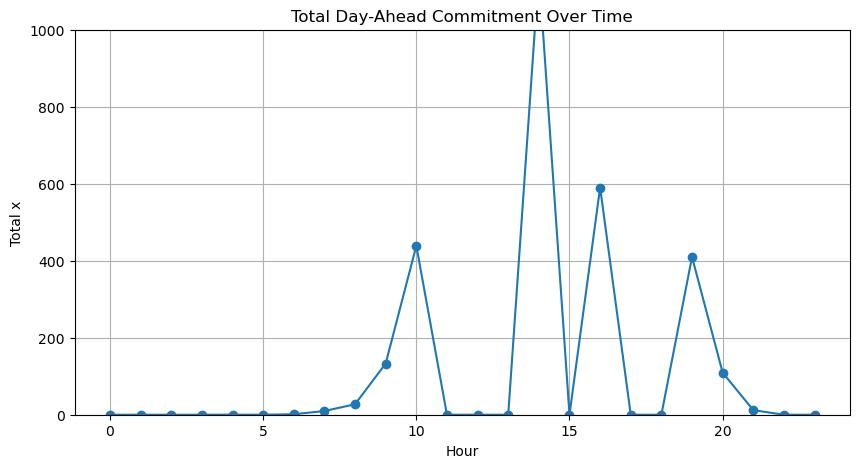

In [79]:
print("\n[SET MODEL] Day-Ahead Commitment (alpha values):")
total_agg_commit = 0
for t in range(T):
    alpha_t = a[t].X
    total_agg_commit += alpha_t
    # print(f"Time {t}: {alpha_t:.2f}")
print(f"TOTAL: {total_agg_commit:.2f}")

plt.figure(figsize=(10, 5))
plt.plot(range(T), a_vals, marker='o')
plt.title("Total Day-Ahead Commitment Over Time")
plt.xlabel("Hour")
plt.ylabel("Total x")
plt.ylim(0,1000)
plt.grid(True)
plt.show()

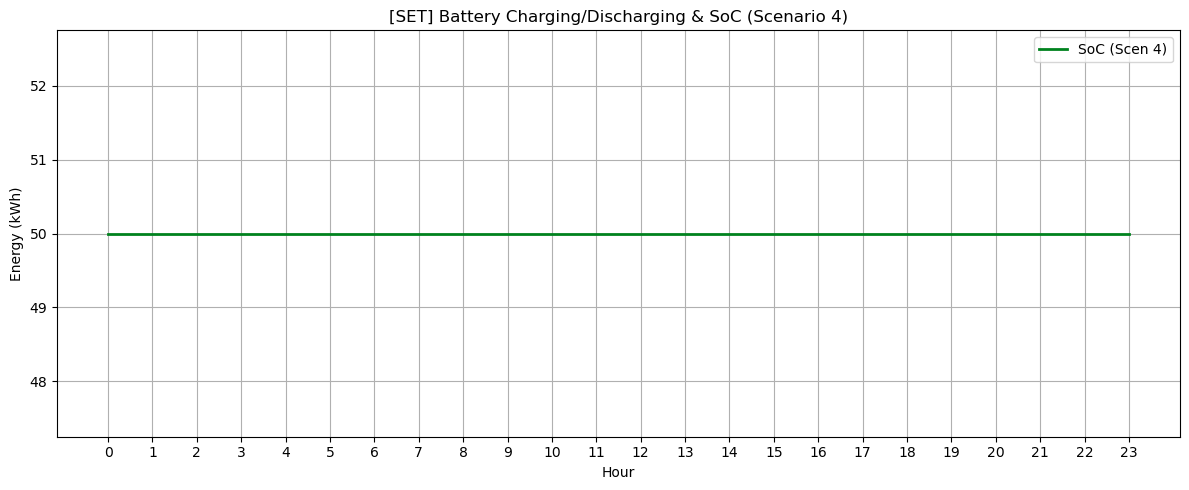

In [80]:
s = 4
gc_single = gc_vals[:, s]  # (T,)
gd_single = gd_vals[:, s]
g_single  = g_vals[:, s]
hours = np.arange(T)

plt.figure(figsize=(12, 5))
# plt.step(hours, gc_single, where='post', label=f"Charge (Scen {s})", marker='^')
# plt.step(hours, gd_single, where='post', label=f"Discharge (Scen {s})", marker='v')
plt.step(hours, g_single, where='post', label=f"SoC (Scen {s})", color='#00821E', linewidth=2)

plt.title(f"[SET] Battery Charging/Discharging & SoC (Scenario {s})")
plt.xlabel("Hour")
plt.ylabel("Energy (kWh)")
plt.xticks(hours)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()